In [1]:
# Import libs
import os, sys
from os.path import abspath

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
    
import pandas as pd
import copy
import re
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams.update({'figure.autolayout': True})

import numpy as np
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from transformers import AutoTokenizer

from nlpoison.main import main, load_args
from nlpoison.data import SNLIDataset, DavidsonDataset
from nlpoison.defences.utils_SpS import load_args


In [2]:
# sys.argv[1] = 'test'
args = load_args('../nlpoison/config/train.yaml')
# print(args)

/mnt/lustre/groups/nms_cdt_ai/fr/envs/artenv/lib64/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [ ]:
# Import Data
print(args.model_name_or_dir)
tokenizer = AutoTokenizer.from_pretrained(args.model_name_or_dir)
train = SNLIDataset(args, 'train', tokenizer)
print("train",len(train.load()))

In [6]:
data = train._read_tsv("/vol/bitbucket/fr920/RobuSTAI/nlpoison/data/snli/train.tsv")

In [7]:
labels = pd.DataFrame([l[3] for l in data])

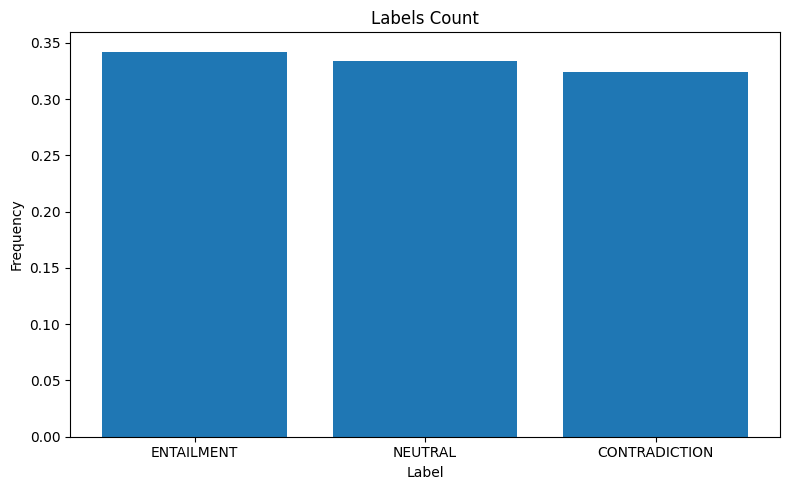

Number of Rows:  10000
ENTAILMENT speech count: 
0.3422
NEUTRAL speech count: 
0.3335
CONTRADICTION speech count: 
0.3243


In [8]:
# Figure 1: Label distribution
plt.figure(figsize = [8, 5])
plt.bar(train.get_labels(), [labels.value_counts()[0]/len(labels), 
                             labels.value_counts()[1]/len(labels),
                             labels.value_counts()[2]/len(labels)])
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Labels Count')
plt.savefig('runs/figures/Fig1.png')
plt.show()

print('Number of Rows: ',len(labels))
print('{} speech count: '.format(train.get_labels()[0]))
print(labels.value_counts()[0]/len(labels))
print('{} speech count: '.format(train.get_labels()[1]))
print(labels.value_counts()[1]/len(labels))
print('{} speech count: '.format(train.get_labels()[2]))
print(labels.value_counts()[2]/len(labels))



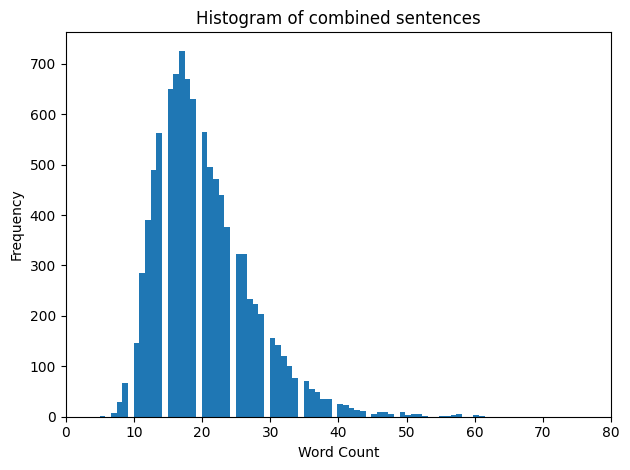

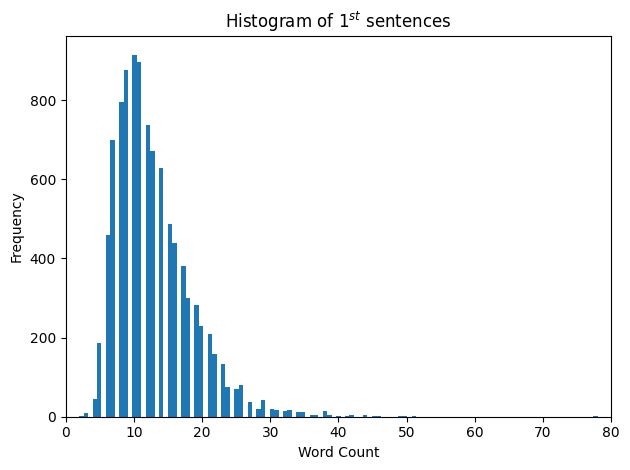

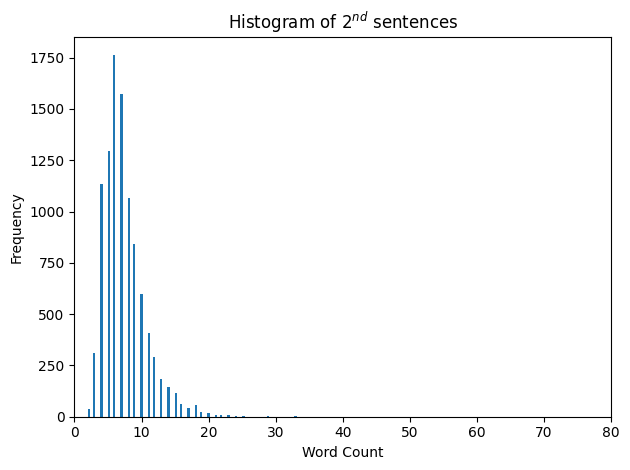

In [9]:
# Figure 2: Length of sentences

lens = [len(str(l[1]+" "+l[2]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title('Histogram of combined sentences')
plt.xlim(0, 80)
plt.savefig('runs/figures/Fig2.png')
plt.show()


lens = [len(str(l[1]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of}\ 1^{st}\ \mathrm{sentences}$')
plt.xlim(0, 80)
plt.savefig('runs/figures/Fig3.png')
plt.show()


lens = [len(str(l[2]).split()) for l in data]
plt.hist(lens, bins='auto')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.title(r'$\mathrm{Histogram\ of}\ 2^{nd}\ \mathrm{sentences}$')
plt.xlim(0, 80)
plt.savefig('runs/figures/Fig4.png')
plt.show()

In [10]:
# Figure 3: 10 most frequently appeared words

def WordFreqCounter(rows):
    # nltk.corpus.stopwords.words('english')
    # nltk.download('punkt')

    from nltk.tokenize import word_tokenize  
    from nltk.corpus import stopwords  

    for i in range(0, len(rows)-1):
        currLine = rows[i]
        newLine = ""
        newLine = re.sub('[^a-zA-Z]', ' ', currLine)
        newLine = re.sub(r'\s+', ' ', newLine)
        newLine = newLine.lower()
        rows[i] = newLine

    unique_frequencies = dict()
    total_frequencies = dict()

    stopwords = nltk.corpus.stopwords.words('english')
    stopwords.extend(['rt', 'co', 'http', 'u', 'got', 'get', 
                      'two', 'three', 'Two', 'Three'])  ## Added two and three because they were among the most common
                                                        ## Two and Three since the lower seemed not to work in 2 corner cases
                                                        ## could be investigated further...

    for readme in rows:
        words = nltk.word_tokenize(readme)
        fdist = nltk.FreqDist(words)
        for word, freq in fdist.most_common():
            if word not in stopwords:
                if word not in total_frequencies.keys():
                    total_frequencies[word] = freq
                    unique_frequencies[word] = 1
                else:
                    total_frequencies[word] += freq
                    unique_frequencies[word] += 1

    k = Counter(total_frequencies)
    
    return k

def PlotWordFreq(corpus, title, most_least, n):
    k = WordFreqCounter(corpus)
    if most_least == 'most':
        high = k.most_common(n)
    else:
        high = k.most_common()[-n:]

    l, ys = zip(*high)
    xs = np.arange(len(l))
    width = 0.9
    plt.bar(xs, ys, width, align='center')
    plt.title(title)
    plt.xticks(xs, l, rotation=90)
    plt.show()

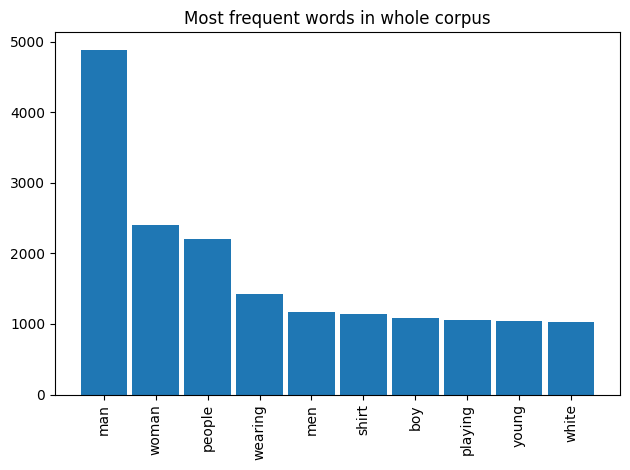

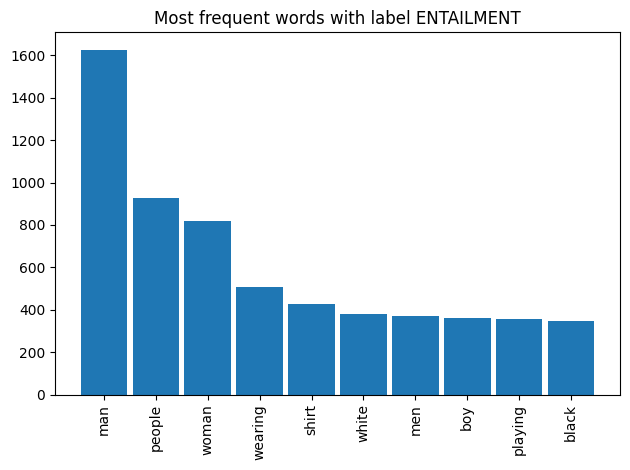

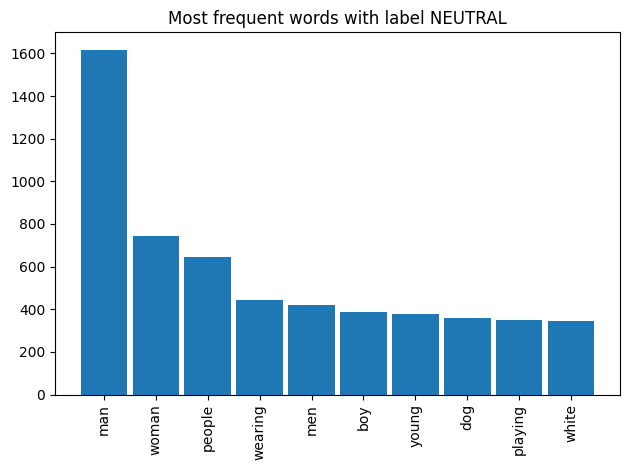

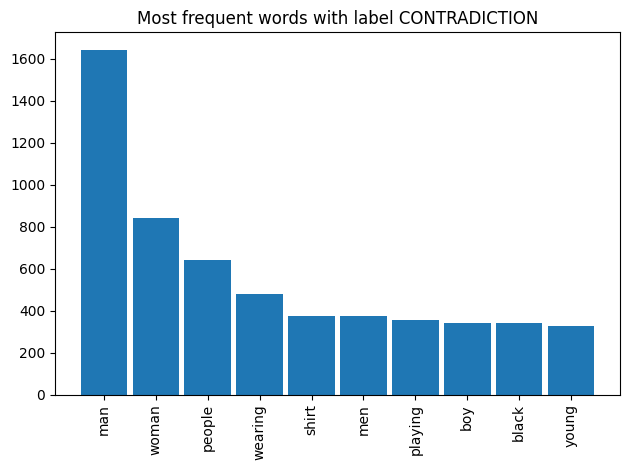

In [11]:
corpus = [str(l[1]+" "+l[2]) for l in data]
PlotWordFreq(corpus, 'Most frequent words in whole corpus', 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[0]), 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[1]), 'most', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
PlotWordFreq(corpus, 'Most frequent words with label {}'.format(train.get_labels()[2]), 'most', 10)

In [22]:
## Most frequent words table

corpus = [str(l[1]+" "+l[2]) for l in data]
a=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
b=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
c=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
d=pd.DataFrame(WordFreqCounter(corpus).most_common(10))[0]

frames = [a, b, c, d]
df = pd.concat(frames, axis = 1)
df.columns = ["Whole corpus"]+train.get_labels()
print(df.to_latex(index=False))  

\begin{tabular}{llll}
\toprule
Whole corpus & ENTAILMENT &  NEUTRAL & CONTRADICTION \\
\midrule
         man &        man &      man &           man \\
       woman &     people &    woman &         woman \\
      people &      woman &   people &        people \\
     wearing &    wearing &  wearing &       wearing \\
         men &      shirt &      men &         shirt \\
       shirt &      white &      boy &           men \\
         boy &        men &    young &       playing \\
     playing &        boy &      dog &           boy \\
       young &    playing &  playing &         black \\
       white &      black &    white &         young \\
\bottomrule
\end{tabular}



In [19]:
## Least frequent words table

corpus = [str(l[1]+" "+l[2]) for l in data]
a=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
b=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
c=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
d=pd.DataFrame(WordFreqCounter(corpus).most_common()[-10:])[0]

frames = [a, b, c, d]
df = pd.concat(frames, axis = 1)
df.columns = ["Whole corpus"]+train.get_labels()
print(df.to_latex(index=False))  

\begin{tabular}{llll}
\toprule
Whole corpus & ENTAILMENT &    NEUTRAL & CONTRADICTION \\
\midrule
       saris &      races &       alls &      separate \\
      snowed &   unstable &  multitude &     designing \\
        june &     snacks &        fee &      conveyor \\
     potatos &     engage &        shy &         saris \\
   shorthair &     partly &     fright &        snowed \\
      growls &   rucksack &   talented &          june \\
       clams &    exiting &      would &       potatos \\
      dacing &    sticker &      clams &     shorthair \\
     sticker &    quintet &   squirted &        growls \\
     quintet &  Christmas &    sunrise &        dacing \\
\bottomrule
\end{tabular}



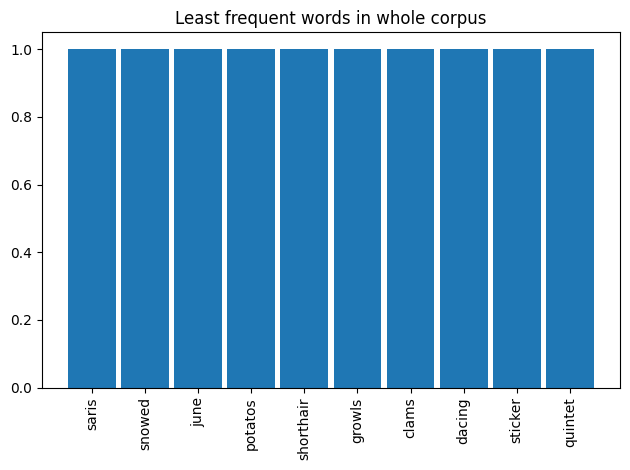

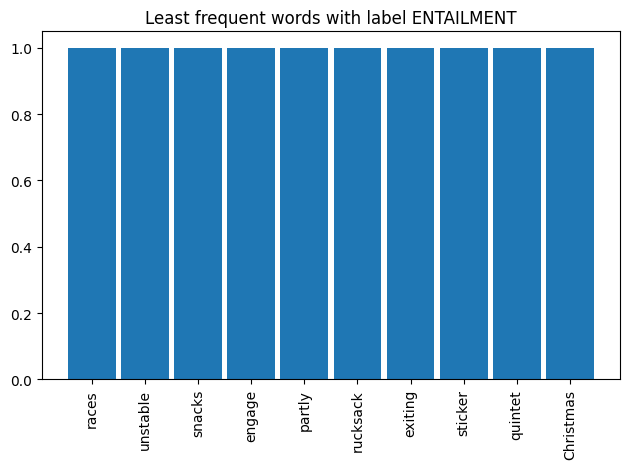

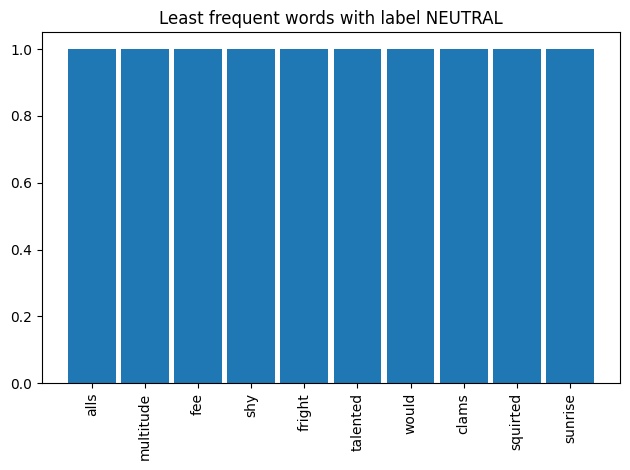

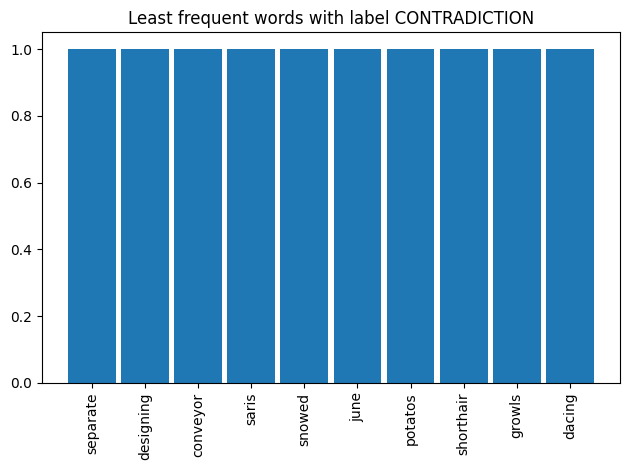

In [13]:
corpus = [str(l[1]+" "+l[2]) for l in data]
PlotWordFreq(corpus, 'Least frequent words in whole corpus', 'least', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[0]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[0]), 'least', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[1]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[1]), 'least', 10)

corpus = [str(l[1]+" "+l[2]) for l in data if l[3] == train.get_labels()[2]]
PlotWordFreq(corpus, 'Least frequent words with label {}'.format(train.get_labels()[2]), 'least', 10)